## Process Edinburgh track data

In [1]:
import numpy as np
import pandas as pd

def parse_track_line(line):
    """
    Parse a track line in format: TRACK.R2=[[119 447 358]; [123 444 359]; [127 440 360]]
    Returns: track_id and list of (x, y, time) tuples
    """
    # Split into identifier and data parts
    identifier, data = line.split('=')
    
    # Extract track ID (R2 from TRACK.R2)
    track_id = identifier.split('.')[1]
    
    # Clean up the data string and split into points
    # data = data.strip('[] ')  # Remove outer brackets
    # print(data)
    # points = data.split(';')  # Split into individual points
    track_points = []
    for group in data.split(";"):
        group = group.strip("[] ")
        if group:  # Skip empty strings
            # print(group)  # Will print: 1,2,3 then 4,5,6 then 7,8,9
            numbers = [int(x) for x in group.split(" ") if x.isdigit()]
            # print(numbers)  # Will print: [1, 2, 3] then [4, 5, 6] then [7, 8, 9]
            if numbers:
                track_points.append(numbers)
    
    return track_id, track_points

# Example usage:
def parse_track_file(filename):
    """
    Parse the track file and return structured data
    """
    tracks = {}
    # Add file parsing logic here
    # For your format, you'll need to parse the TRACK.Rx entries
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith(' TRACK.R'):
                track_id, points = parse_track_line(line)
                # track_id, x, y, t = line.split()
                tracks[track_id] = points
    return tracks


In [2]:
# calculate distance of each agent
def cal_distance(x_pos, y_pos, pixel_to_meter=0.0247):
    """
    Calculate the real-world distance traveled
    
    Parameters:
    x_pos, y_pos: position coordinates in pixels
    pixel_to_meter: conversion ratio (24.7mm = 0.0247m per pixel)
    
    Returns:
    distance in meters
    """
    x = x_pos.values
    y = y_pos.values
    
    # Calculate pixel distance
    pixel_distance = np.sqrt(np.diff(x)**2 + np.diff(y)**2).sum()
    
    # Convert to meters
    real_distance = pixel_distance * pixel_to_meter
    
    return real_distance

def calculate_speed_and_distance(group):
    """
    Calculate speed and distance for a group of points in a trajectory
    Returns both speed (m/s) and distance (m)
    """
    if len(group) < 2:
        return pd.Series({'speed': 0.0, 'distance': 0.0})
        
    # Sort by timestamp
    group = group.sort_values('timestamp')
    
    # Calculate distances between consecutive points
    x_diff = np.diff(group['x'])
    y_diff = np.diff(group['y'])
    
    # Calculate pixel distances
    pixel_distances = np.sqrt(x_diff**2 + y_diff**2)
    
    # Convert to meters (24.7mm per pixel)
    distances = pixel_distances * 0.0247
    total_distance = np.sum(distances)
    
    # Calculate time difference in seconds
    time_diff = (group['timestamp'].max() - group['timestamp'].min()) * 0.1
    
    # Calculate speed (m/s)
    speed = total_distance / time_diff if time_diff > 0 else 0
    
    return pd.Series({'speed': speed, 'distance': total_distance})


In [3]:
def get_tracks_dataframe(tracks, time_window=50*2):
    track_ids = []
    xs = []
    ys = []
    timestamps = []
    for track_id, points in tracks.items():
        for x, y, t in points:
            track_ids.append(track_id)
            xs.append(x)
            ys.append(y)
            timestamps.append(t)
# Create the DataFrame
    df = pd.DataFrame({
        'track_id': track_ids,
        'x': xs,
        'y': ys,
        'timestamp': timestamps
    })
    bins = np.arange(df['timestamp'].min(), df['timestamp'].max() + time_window, time_window)
    # calculate time interval
    df['time_interval'] = pd.cut(df['timestamp'], bins=bins)
    # calculate speed
    # speeds, distances = df.groupby(["track_id", "time_interval"], observed=True).apply(calculate_speed).reset_index(name='speeds')
    # df = pd.merge(df, speeds, on=["track_id", "time_interval"])
    # df = pd.merge(df, distances, on=["track_id", "time_interval"])
    speed_distance_df = df.groupby(["track_id", "time_interval"], observed=True).apply(calculate_speed_and_distance)
    speed_distance_df = speed_distance_df.reset_index()
    df = pd.merge(df, speed_distance_df, on=["track_id", "time_interval"])
    return df


In [4]:
# tracks = parse_track_file("tracks.01Sep.txt")
tracks = parse_track_file("dataset/tracks.26Aug.txt")
df = get_tracks_dataframe(tracks)
# Display the first few rows
df["speed"].describe()

/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_87089/1848600577.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speed_distance_df = df.groupby(["track_id", "time_interval"], observed=True).apply(calculate_speed_and_distance)


count    191980.000000
mean          1.285925
std           0.594988
min           0.000000
25%           0.925050
50%           1.423475
75%           1.702293
max           4.405679
Name: speed, dtype: float64

Statistics of tracks per interval:
count    3038.000000
mean        1.298552
std         1.720723
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        15.000000
Name: track_id, dtype: float64


/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_87089/2975038182.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tracks_per_interval = df.groupby('time_interval')['track_id'].nunique()


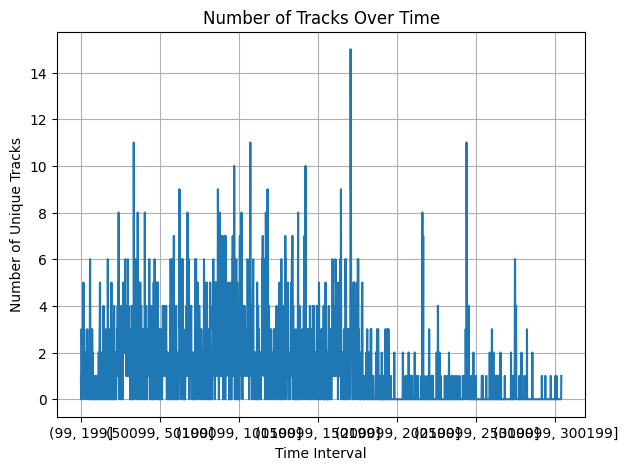

In [ ]:
import matplotlib.pyplot as plt
# 1. Count tracks per time interval
tracks_per_interval = df.groupby('time_interval')['track_id'].nunique()

# Basic statistics
print("Statistics of tracks per interval:")
print(tracks_per_interval.describe())

# 2. Visualize the distribution
plt.figure(figsize=(15, 5))

# Time series plot
plt.subplot(1, 2, 1)
tracks_per_interval.plot()
plt.title('Number of Tracks Over Time')
plt.xlabel('Time Interval')
plt.ylabel('Number of Unique Tracks')
plt.grid(True)

# total tracks


In [9]:
tracks_per_interval.values

array([1, 0, 1, ..., 0, 0, 1])

In [84]:
# set flow counter
flow_counters = {
    "FlowCounter1": [(450, 0), (640, 100)],
    "FlowCounter2": [(85, 325), (150, 445)],
    "FlowCounter3": [(5, 200), (5, 300)],
    "FlowCounter4": [(100, 5), (310, 5)],
    "FlowCounter5": [(580, 445), (640, 445)],
    "FlowCounter6": [(215, 425), (360, 425)],
}

flow_counters_normal_vector = {}
for key in flow_counters.keys():
    x1, y1 = flow_counters[key][0]
    x2, y2 = flow_counters[key][1]
    flow_counters_normal_vector[key] = np.array(((y2-y1), -(x2-x1)))


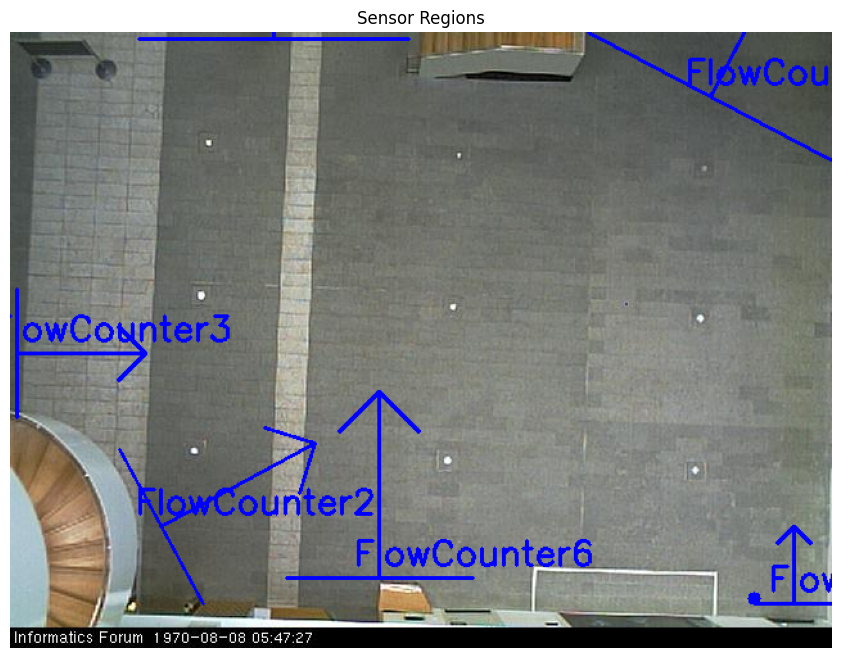

Visualization saved to sensor_regions_visualization.jpg


In [67]:
# show the defined region in the original image
# (640, 480)
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_sensor_regions(image_path, regions, normal_vectors):
    """
    Visualize sensor regions on the image
    
    Parameters:
    image_path: str, path to the image file
    regions: dict, containing region names and their coordinates (x1,y1,x2,y2)
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    # Convert BGR to RGB for matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Make a copy for drawing
    img_with_regions = img.copy()
    
    # Draw each region
    for region_name, coords in regions.items():
        (x1, y1), (x2, y2) = coords
        # color = colors.get(region_name, colors["other"])
        color = (0, 0, 255)
        # Draw rectangle
        # cv2.rectangle(img_with_regions, (x1, y1), (x2, y2), color, 2)
        # draw line
        cv2.line(img_with_regions, (x1, y1), (x2, y2), color, 2)
        # draw normal vector
            # Add label
        mid_x = (x1 + x2) // 2
        mid_y = (y1 + y2) // 2
        cv2.arrowedLine(img_with_regions, (mid_x, mid_y), (mid_x + normal_vectors[region_name][0], mid_y + normal_vectors[region_name][1]), color, 2, tipLength=0.3)
        

        cv2.putText(img_with_regions, region_name, (mid_x-20, mid_y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    # draw a point
    point = np.array([579.4, 441.8])
    cv2.circle(img_with_regions, (int(point[0]), int(point[1])), 5, (0, 0, 255), -1)
    
    # Display using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(img_with_regions)
    plt.axis('off')
    plt.title('Sensor Regions')
    plt.show()
    
    # Optionally save the visualization
    output_path = 'sensor_regions_visualization.jpg'
    cv2.imwrite(output_path, cv2.cvtColor(img_with_regions, cv2.COLOR_RGB2BGR))
    print(f"Visualization saved to {output_path}")

# Visualize the regions
try:
    visualize_sensor_regions("fig/ceil250.jpg", flow_counters, flow_counters_normal_vector)
except Exception as e:
    print(f"Error: {e}")

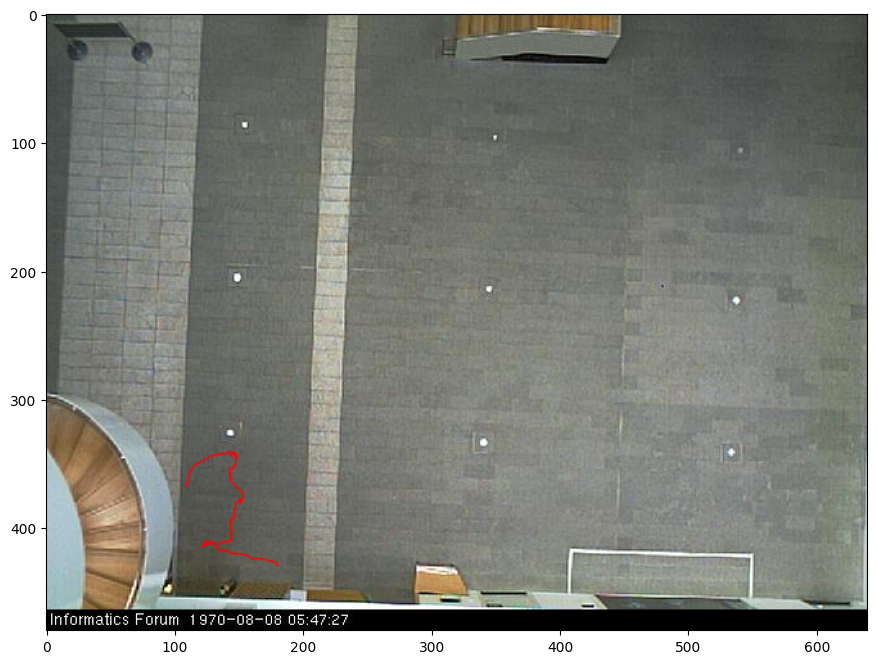

In [85]:
# plot trajectory on the image
img = cv2.imread("fig/ceil250.jpg") # Move image loading out of the loop
n = 0
for track_id in df["track_id"].unique():
    line = df[df["track_id"] == track_id][["x", "y"]].values    
    if track_id == "R4":
        # plot the line, 
        for i in range(len(line)-1):
            # linetype dot
            cv2.line(img, (int(line[i][0]), int(line[i][1])), (int(line[i+1][0]), int(line[i+1][1])), (0, 0, 255), 1, lineType=cv2.LINE_AA)
    # n += 1
    # if n > 100:
    #     break
        break
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Convert to RGB
plt.show()

In [38]:
df[df["location"] == "FlowCounter3"]["track_id"].nunique()

38

In [69]:
# check if the track crosses the sensor region
from shapely.geometry import LineString, Point
from shapely.ops import nearest_points

def cal_distance_to_line(trajectory, line):
    x1, y1 = line[0]
    x2, y2 = line[1]
    x, y = trajectory
    distance = abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return distance

def check_inarea(trajectory, line):
    x1, y1 = line[0]
    x2, y2 = line[1]
    x, y = trajectory
    if x >= x1-2 and x <= x2+2 and y >= y1-2 and y <= y2+2:
        return True

def crosses_line(trajectory, line, proximity_threshold_meters=0.5):
    """
    Check if trajectory crosses or comes very close to a line
    
    Parameters:
    trajectory: array of points [(x1,y1), (x2,y2),...]
    line: array of two points defining line segment [(x1,y1), (x2,y2)]
    proximity_threshold_meters: distance in meters to consider as "close enough" to cross (default 0.5m)
    
    Returns:
    numpy array of intersection/closest point or False
    """
    # Convert meters to pixels (1 pixel = 24.7mm = 0.0247m)
    PIXEL_TO_METER = 0.0247
    proximity_threshold_pixels = proximity_threshold_meters / PIXEL_TO_METER
    inarea = False

    if trajectory.ndim == 1: # if the trajectory is a single point, then check if it is close to the line
        # cal distance to the line
        distance_pixels = cal_distance_to_line(trajectory, line)
        distance_meters = distance_pixels * PIXEL_TO_METER
        # check if the point is in the area of the line
        if distance_meters <= proximity_threshold_meters and check_inarea(trajectory, line):
            return np.array([trajectory[0], trajectory[1]])
        else:
            return False
    # Convert trajectory and line to Shapely objects
    trajectory_line = LineString(trajectory)
    line_segment = LineString(line)
    
    # First check direct intersection
    if trajectory_line.intersects(line_segment):
        intersection = trajectory_line.intersection(line_segment)
        # print("intersection", intersection.geom_type)
        if intersection.geom_type == 'MultiPoint':
            point = list(intersection.geoms)[0]
            return np.array([point.x, point.y])
        elif intersection.geom_type == 'Point':
            return np.array([intersection.x, intersection.y])
        elif intersection.geom_type == 'LineString':
            return np.array([intersection.xy[0][0], intersection.xy[1][0]])
    
    # If no direct intersection, check proximity
    else:
        # Find closest points between trajectory and line
        closest_points = nearest_points(trajectory_line, line_segment)
        min_distance_pixels = closest_points[0].distance(closest_points[1])
        min_distance_meters = min_distance_pixels * PIXEL_TO_METER

        # check if the closest point is in the area of the line, check_inarea: if it is in the boundary of the line
        if min_distance_pixels <= proximity_threshold_pixels and check_inarea((closest_points[0].x, closest_points[0].y), line):
        # if min_distance_pixels <= proximity_threshold_pixels:    
            closest_point = closest_points[0]
            return np.array([closest_point.x, closest_point.y])
            
        # Optional: print distance for debugging
        # print(f"Minimum distance: {min_distance_meters:.2f} meters ({min_distance_pixels:.1f} pixels)")
    
    return False

# check if the agent crosses the line, and the direction of the agent
def process_agent(agent_traj, flow_counters, counter, normal_vector):
    if len(agent_traj) > 5:
        traj_line = agent_traj[["x", "y"]].values
        point = crosses_line(traj_line, flow_counters[counter])
        
        if isinstance(point, np.ndarray):
            # Calculate direction
            direction = point - traj_line[0]
            
            # Check for zero vectors to avoid division by zero
            dir_norm = np.linalg.norm(direction)
            normal_norm = np.linalg.norm(normal_vector[counter])
            if dir_norm == 0:
                # print(f"Direction vector is zero: {point}, {traj_line[0]}, {traj_line[-1]}")
                direction = traj_line[-1] - traj_line[0]
                dir_norm = np.linalg.norm(direction)
            

            cos = np.dot(direction, normal_vector[counter]) / (dir_norm * normal_norm)
            # Clip cos value to [-1, 1] to avoid numerical errors
            cos = np.clip(cos, -1.0, 1.0)
            return 1, 1 if cos <= 0 else 0, 1 if cos > 0 else 0

    return 0, 0, 0

def get_flows(trajectory_dataframes, flow_counters, flow_counter_normal_vector):
    # Initialize an empty dictionary to store the flow data
    flow = {}

    # Iterate over each counter in the flow_counters dictionary
    for counter in flow_counters.keys():

        # Initialize two lists to store the counts of agents moving left and right
        left_count_list = []
        right_count_list = []

        # Group the trajectory data by time intervals and iterate over each group
        for inv, group in trajectory_dataframes.groupby('time_interval', observed=True):

            # Sort the group by time in ascending order and select the columns "Agent ID", "x_pos", "y_pos"
            traj = group.sort_values(by="timestamp", ascending=True)[["track_id", "x", "y"]]

            # Apply the process_agent function to each agent in the group and store the results in 'counts'
            counts = traj.groupby('track_id', observed=True).apply(process_agent, flow_counters=flow_counters,
                                                                   counter=counter, normal_vector=flow_counter_normal_vector,
                                                                     include_groups=False)
            # print(counts)

            # Append the sum of the second element (indicating left movement) of each count to the left_count_list
            left_count_list.append(counts.apply(lambda x: x[1]).sum())

            # Append the sum of the third element (indicating right movement) of each count to the right_count_list
            right_count_list.append(counts.apply(lambda x: x[2]).sum())

        # Store the left and right count lists in the flow dictionary with keys as counter name appended with "_left" and "_right"
        flow[counter+"_left"] = left_count_list
        flow[counter+"_right"] = right_count_list

    # Return the flow dictionary
    return flow

In [70]:
def check_location(traj, flow_counters):
    for region in flow_counters.keys():
        (x1, y1), (x2, y2) = flow_counters[region][0], flow_counters[region][1]
        if isinstance(crosses_line(traj, flow_counters[region]), np.ndarray):
            return region
    return "other"

def assign_location(df, flow_counters):
    """According to the x, y, and the flow counter, assign the location of the agent,
    if the agent is in the region, then assign the location as the region name"""
    
    df["location"] = df.apply(lambda x: check_location(x[["x", "y"]].values, flow_counters), axis=1)
    return df

In [9]:
counter = "FlowCounter1"
crosses_line(df[df["track_id"] == "R1"][["x", "y"]].values, flow_counters["FlowCounter5"])

array([603., 445.])

In [41]:
for index, row in df.iterrows():
    print(row[["x", "y"]].values.shape)
    cross = crosses_line(row[["x", "y"]].values, flow_counters["FlowCounter5"])
    print(cross)
    break

(2,)
False


In [92]:
# assign location to the df
df = assign_location(df, flow_counters)


In [44]:
df[df["track_id"] == "R6"]["location"].unique()

array(['other', 'FlowCounter4', 'FlowCounter2'], dtype=object)

In [ ]:
m = 0
for track_id in df["track_id"].unique():
    n = df[df["track_id"] == track_id]["location"].nunique()
    if n == 3:
        # m += 1
        print(df[df["track_id"] == track_id]["location"].unique())
print(m)

In [108]:
def calculate_travel_times(df, choice="avg"):
    """
    Calculate travel times between any pair of flow counter crossings
    (not just consecutive pairs)
    
    Parameters:
    df: DataFrame with columns ['track_id', 'timestamp', 'location']
    """
    # Get only the flow counter crossings (exclude "other" locations)
    filtered_df = df[df['location'] != 'other'].copy()
    
    shift_filtered_df = filtered_df.groupby("track_id")[["timestamp", "location"]].shift(-1)
    filtered_df["next_location"] = shift_filtered_df["location"]
    filtered_df["time_diff"] = shift_filtered_df["timestamp"] - filtered_df["timestamp"]

    filtered_df = filtered_df.dropna(subset=["next_location"])
    # extract the data only with different location and next_location
    filtered_df = filtered_df[filtered_df["location"] != filtered_df["next_location"]]

    # remove the outlier of speed and travel time of each data point
    filtered_df = filtered_df[(filtered_df["speed"] < filtered_df["speed"].quantile(0.95)) & (filtered_df["speed"] > filtered_df["speed"].quantile(0.05))]
    filtered_df = filtered_df[(filtered_df["time_diff"] < filtered_df["time_diff"].quantile(0.95)) & (filtered_df["time_diff"] > filtered_df["time_diff"].quantile(0.05))]
    #avg speed, travel time, distance
    if choice == "avg":
        average_speed = filtered_df.groupby(['location', 'next_location'])["speed"].mean()
        averge_travle_time = filtered_df.groupby(['location', 'next_location'])["time_diff"].mean()
        average_distance = averge_travle_time * average_speed
        filtered_df = pd.merge(filtered_df, average_speed.rename('avg_speed'), on=["location", "next_location"])
        filtered_df = pd.merge(filtered_df, averge_travle_time.rename('avg_travel_time'), on=["location", "next_location"]) 
        filtered_df = pd.merge(filtered_df, average_distance.rename('avg_distance'), on=["location", "next_location"])
        filtered_df["avg_travel_time"] = filtered_df["avg_travel_time"].apply(lambda x: x/10)
        filtered_df["avg_distance"] = filtered_df["avg_distance"].apply(lambda x: x/10)
    elif choice == "median":
    # median speed, travel time, distance
        median_speed = filtered_df.groupby(['location', 'next_location'])["speed"].median()
        median_travel_time = filtered_df.groupby(['location', 'next_location'])["time_diff"].median()
        median_distance = median_travel_time * median_speed
        filtered_df = pd.merge(filtered_df, median_speed.rename('median_speed'), on=["location", "next_location"])
        filtered_df = pd.merge(filtered_df, median_travel_time.rename('median_travel_time'), on=["location", "next_location"])
        filtered_df = pd.merge(filtered_df, median_distance.rename('median_distance'), on=["location", "next_location"])
        filtered_df["median_travel_time"] = filtered_df["median_travel_time"].apply(lambda x: x/10)
        filtered_df["median_distance"] = filtered_df["median_distance"].apply(lambda x: x/10)

    return filtered_df

In [109]:
f_df = calculate_travel_times(df, choice="median")

In [110]:
f_df

,track_id,x,y,timestamp,time_interval,speed,distance,location,next_location,time_diff,median_speed,median_travel_time,median_distance
0,R3,147,416,1637,"(1599, 1699]",1.452756,14.382282,FlowCounter2,FlowCounter5,67.0,1.660635,7.3,12.122633
1,R4,607,445,2205,"(2199, 2299]",1.413365,10.176227,FlowCounter5,FlowCounter6,61.0,1.350379,6.5,8.777466
2,R6,607,445,2205,"(2199, 2299]",1.350379,9.722731,FlowCounter5,FlowCounter6,61.0,1.350379,6.5,8.777466
3,R9,138,386,3968,"(3899, 3999]",1.128669,4.966144,FlowCounter2,FlowCounter6,60.0,1.128669,3.3,3.724608
4,R13,336,427,7518,"(7499, 7599]",1.131092,9.161842,FlowCounter6,FlowCounter5,54.0,1.338706,5.4,7.229011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,R1979,579,86,278698,"(278599, 278699]",1.452167,2.613900,FlowCounter1,FlowCounter4,65.0,1.472673,5.1,7.510633
930,R1980,578,89,278693,"(278599, 278699]",2.117821,2.329603,FlowCounter1,FlowCounter4,70.0,1.472673,5.1,7.510633
931,R1987,305,6,291505,"(291499, 291599]",1.541524,6.474401,FlowCounter4,FlowCounter1,40.0,1.510800,4.6,6.949678
932,R1989,311,6,297180,"(297099, 297199]",1.528180,2.903541,FlowCounter4,FlowCounter1,39.0,1.510800,4.6,6.949678


In [106]:
import seaborn as sns
def analyze_location_transitions(filtered_df):
    """
    Analyze travel times between locations using pre-processed DataFrame
    
    Parameters:
    filtered_df: DataFrame with columns ['location', 'next_location', 'time_diff']
    """

    # Create transition matrix
    transition_matrix = pd.pivot_table(
        filtered_df,
        values='avg_distance',
        index='location',
        columns='next_location',
        aggfunc='median'
    ).round(2)

        # Calculate statistics for each location pair
    stats = filtered_df.groupby(['location', 'next_location']).agg({
        'time_diff': ['count', 'mean', 'std', 'min', 'max']
    }).round(2)
    
    print("\nTransition Matrix (Average Time in seconds):")
    print(transition_matrix)
    
    # Visualize distributions
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=filtered_df, x='location', y='distance', hue='next_location')
    plt.title('Travel Distance between Locations')
    plt.xlabel('From Location')
    plt.ylabel('Time Difference (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return stats, transition_matrix


Transition Matrix (Average Time in seconds):
next_location  FlowCounter1  FlowCounter2  FlowCounter3  FlowCounter4  \
location                                                                
FlowCounter1            NaN         13.14         12.36          8.19   
FlowCounter2          13.26           NaN          4.88         10.59   
FlowCounter3          13.90          5.98           NaN          5.10   
FlowCounter4           7.79         10.17          7.43           NaN   
FlowCounter5           9.89         11.72           NaN         15.22   
FlowCounter6          11.06          3.40          8.58         11.64   

next_location  FlowCounter5  FlowCounter6  
location                                   
FlowCounter1           9.84         11.98  
FlowCounter2          12.90          4.59  
FlowCounter3            NaN          5.71  
FlowCounter4          15.60         10.93  
FlowCounter5            NaN          9.14  
FlowCounter6           8.33           NaN  


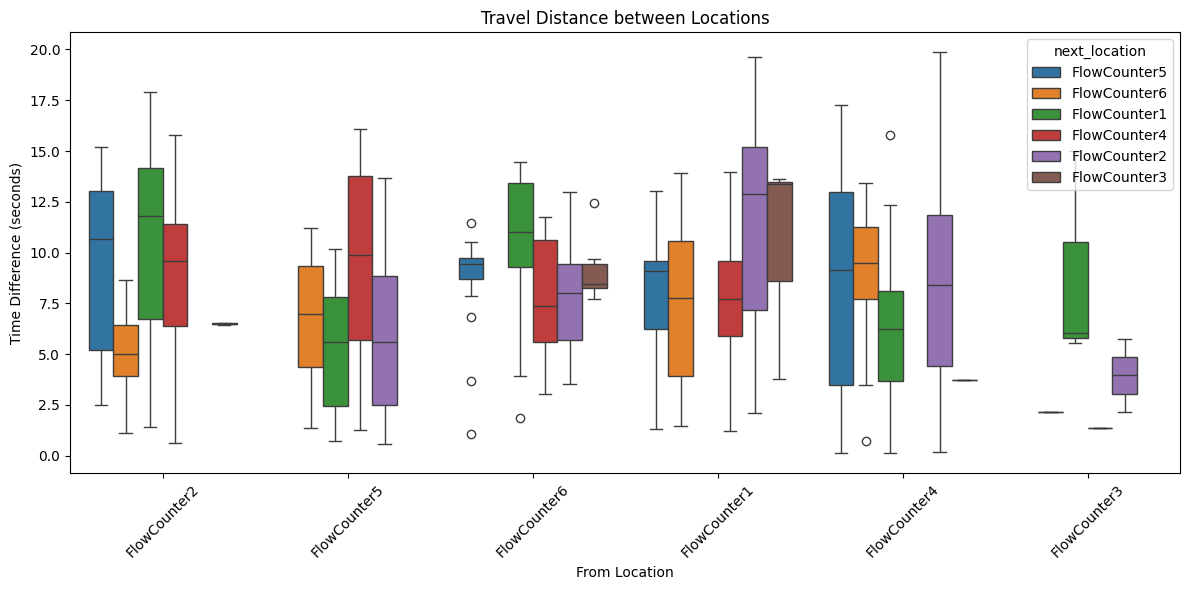

In [107]:
stats, transitions = analyze_location_transitions(f_df)

In [111]:
flow = get_flows(df, flow_counters, flow_counters_normal_vector)


/Users/mmai/anaconda3/envs/dgl/lib/python3.10/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/mmai/anaconda3/envs/dgl/lib/python3.10/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/mmai/anaconda3/envs/dgl/lib/python3.10/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/mmai/anaconda3/envs/dgl/lib/python3.10/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/mmai/anaconda3/envs/dgl/lib/python3.10/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/mmai/anaconda3/envs/dgl/lib/python3.10/site-packages/shapely/linear.

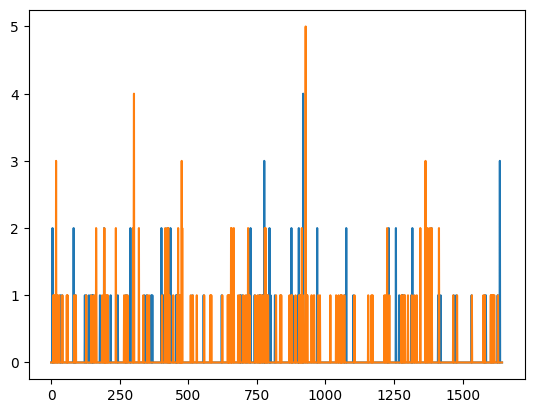

In [112]:
import matplotlib.pyplot as plt
ct = 6
plt.plot(flow[f"FlowCounter{ct}_left"])
plt.plot(flow[f"FlowCounter{ct}_right"])
plt.show()

In [113]:
# Batch process flow data 
import os
dataset_dir = "dataset/"
data_dict = {}
for file in os.listdir(dataset_dir):
    if file.endswith(".txt"):
        tracks = parse_track_file(os.path.join(dataset_dir, file))
        tracks_df = get_tracks_dataframe(tracks)
        flow = get_flows(tracks_df, flow_counters, flow_counters_normal_vector)
        flow_df = pd.DataFrame(flow)
        data_dict[file.split(".")[1]] = flow_df.values

    # break

/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_98578/1848600577.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speed_distance_df = df.groupby(["track_id", "time_interval"], observed=True).apply(calculate_speed_and_distance)
/Users/mmai/anaconda3/envs/dgl/lib/python3.10/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/mmai/anaconda3/envs/dgl/lib/python3.10/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/mmai/anaconda3/envs/dgl/lib/python3.10/site-packages/shapely/linear.py:203: RuntimeWar

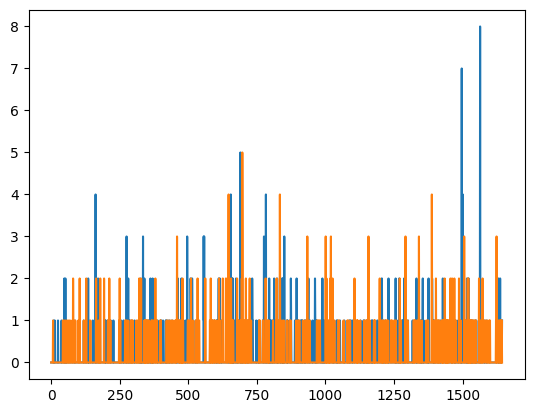

In [117]:
sc = "26Aug"
flow0 = data_dict[sc][:, 0]
flow1 = data_dict[sc][:, 1]
plt.plot(flow0)
plt.plot(flow1)
plt.show()

In [120]:
# save the data dict
import pickle
with open("sc_sensor/edinburgh/flow_data_edinburgh.pkl", "wb") as f:
    pickle.dump(data_dict, f)

In [126]:
# save graphs for 4 datasets
import dgl
import torch
def create_and_save_graphs():
    """Create and save multiple graphs into a single binary file"""
    graphs = []
    
    # Crossroad graph
    src = np.array([0, 0, 0, 3, 3, 3, 5, 5, 5, 6, 6, 6])
    dst = np.array([4, 2, 7, 1, 4, 7, 2, 7, 1, 2, 4, 1])
    g_crossroad = dgl.graph((src, dst))
    g_crossroad.edata['distance'] = torch.FloatTensor([43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]) # 50m
    graphs.append(g_crossroad)
    
    # Train station graph
    src = np.array([3,3,3,
                    4,4,4,
                    7,7,7,
                    22,22,22,
                    23,23,23,23,23,
                    8,8,8,8,8,
                    11, 11, 11, 11, 11,
                    14, 14, 14, 14, 14,
                    18, 18, 18,
                    17, 17, 17, 17, 17,
                    13, 13, 13,
                    21, 21, 21,
                    0, 0, 0,
                    12, 12, 12, 12, 12])
    dst = np.array([5,6,23,
                    2,6,23,
                    2,5,23,
                    2,5,6,
                    9,10,15,16,13,
                    22,10,13,15,16,
                    22,9,15,16,13,
                    22,9,10,16,13,
                    12,1,20,
                    13,15,9,10,22,
                    20,1,19,
                    19,1,12,
                    12,19,20,
                    15,16,9,10,22])
    
    g_station = dgl.graph((src, dst))
    g_station.edata['distance'] = torch.FloatTensor([40,40,28, # 3
                                                 40,50,32, # 4
                                                 40,50,32,
                                                 28,32,32,
                                                 24,24,41,41,35,
                                                 24,50,49,54,65,
                                                 24,50,65,54,49,
                                                 41,54,65,50,32,
                                                 25,47,50,
                                                 32,50,65,54,41,
                                                 25,32,25,
                                                 50,47,25,
                                                 32,47,47,
                                                 32,32,49,49,35])
    graphs.append(g_station)
    
    # Maze graph
    src = np.array([0, 0, 0, 3, 3, 3, 5, 5, 5, 22, 22, 22,
                        23, 23, 23, 18, 18, 18, 20, 20, 20,
                        17, 17, 17, 16, 16, 16, 14, 14, 14,
                        11, 11, 11, 13, 13, 13, 10, 10, 10,
                        4, 4, 4, 9, 9, 9, 7, 7, 7])
    dst = np.array([2, 4, 23, 1, 4, 23, 2, 1, 23, 4, 2, 1,
                        19, 16, 21, 22, 16, 21, 22, 19, 16,
                        22, 19, 21, 12, 10, 15, 17, 10, 12,
                        12, 15, 17, 10, 17, 15, 5, 8, 6,
                        6, 8, 11, 6, 5, 11, 8, 11, 5])
    g_maze = dgl.graph((src, dst))
    g_maze.edata['distance'] = torch.FloatTensor([30, 50, 43, 30, 43, 50, 43,
                                                  50, 50, 50, 50, 43, 43, 50,
                                                  60, 43, 50, 43, 60, 43, 50,
                                                  50, 50, 50, 50, 50, 50, 50,
                                                  60, 43, 43, 60, 50, 43, 50,
                                                  43, 50, 43, 50, 43, 50, 50,
                                                  30, 50, 43, 30, 50, 43])
    graphs.append(g_maze)

    # Edinburgh graph
    src = np.array([0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5,
                        6, 6, 6, 6, 6, 9, 9, 9, 9, 9, 11, 11, 11, 11, 11])
    dst = np.array([2, 4, 7, 8, 10, 4, 7, 1, 8, 10, 7, 1, 8, 10, 2,
                        4, 2, 10, 8, 1, 7, 1, 10, 2, 4, 2, 4, 7, 1, 8])
    g_edinburgh = dgl.graph((src, dst))
    g_edinburgh.edata['distance'] = torch.FloatTensor([12.5, 15.3, 8.2, 9.3, 12.5, 6, 11, 13, 13, 6.1,
                                                        11, 14, 15.5, 5.7, 3, 9, 10.4, 11.7, 15, 7.5,
                                                        15, 9.5, 8.5, 12.5, 16, 4.5, 10, 11.5, 11.5, 8.5])
    graphs.append(g_edinburgh)
    # Save all graphs to a single file
    dgl.save_graphs('./graphs/4graphs.bin', graphs)
    print("Graphs saved successfully!")

create_and_save_graphs()

Graphs saved successfully!
